# Video-based anomaly Detector
This application is an example of how anomaly detection might be used in a camera trap. During the training phase, it first learns what a typical scene contains, and then, during the running phase it highlights areas of subsequent images where it sees something unexpected.

It works by making a stastical profile of each pixel in the image, calculating the mean and standard deviation of the pixel values over time, and then looking for pixel values which are beyond a certain distance from the centre of the value distribution.

To quit the application, press 'q' when one of the output windows has focus.

There are a load of improvements which could be made, but it proves the concept.

### Suggestion for improvement

* Check if the pixel values are actually normally distributed, if not, transform them until they are
* Check for very narrow (low standard deviation) distributions and exclude them, they can be caused by saturated pixels (i.e. bright lights)
* Instead of a single training pass, do a running mean and standard deviation with a set window

Installing the Anaconda Python distribution (<https://www.continuum.io/downloads>) should give you everything needed to run this (with the possible exception of opencv (<http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_setup/py_setup_in_windows/py_setup_in_windows.html>).

<bruce.weir@bbc.co.uk>

In [1]:
from IPython.display import display, clear_output
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import sys, time
import sys
from subprocess import call
from multiprocessing import Process
import multiprocessing
import random
import scipy.stats
from datetime import datetime


        
%pylab inline


Populating the interactive namespace from numpy and matplotlib


c:\program files\python36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### This is the function which gets called when the camera trap is triggered. It is a separate process which plays some sounds. Add your own sound files here (or change it to your own functionality). The 'evt' is part of the multiprocessing package and allows control of secondary processes. (In this case, it stops a new sound being played until the old one is finished)

In [2]:
  
def playSound(evt,):
    
    soundFiles=["/home/brucew/sound.mp3", 
                "/home/brucew/ping.mp3",
               "/home/brucew/cheering.mp3",
               "/home/brucew/foghorn.mp3",
               "/home/brucew/cockerel.mp3"]
    while(True):
        evt.wait()
        print('playSound')
        if sys.platform == 'linux2':
            call(["ffplay", "-nodisp", "-autoexit", random.choice(soundFiles)])
        elif sys.platform == 'darwin':
            call(["afplay","sound.mp3"])
        evt.clear()
    
    


### Start the audio process. This is what will play a sound when it gets triggered by the anomaly detector

In [3]:
evt = multiprocessing.Event()

if __name__ == '__main__':
    p = Process(target=playSound, args=(evt,))
    p.start()

    


### Calculates the probability of 'x', given the mean and standard deviation of the previous samples. Assumes that the samples have a Normal distribution

In [4]:
def gaussian(x, mean, std):
    #check for very small standard deviations
    if(2 * std ** 2 == 0):
        return 1.0
        
    return (1.0/(math.sqrt(2*math.pi) * std)) * math.exp(-((x-mean)**2)/(2*std**2))

# Training process

## Capture the training data. 
Note that the image is scaled down significantly. The scaling interpolation helps to smooth noise in the image (as well as speed later calculations up).
To train on more images, increase the nTrainingFrames variable.

In [5]:
scalingFactor = 0.05;

# 0 is the first webcam. Can also use a file or a URL (for a remote stream for example)
cap = cv2.VideoCapture(0)#'udp://localhost:8090')#'./beans.avi')

#increase nTrainingFrames to get more training samples
nTrainingFrames = 200
trainingFrames = []
nFramesCaptured = 0

while(cap.isOpened()):
    
    ret, frame = cap.read()
    
    res = cv2.resize(frame, None, fx=scalingFactor, fy=scalingFactor, interpolation = cv2.INTER_CUBIC)    

    #currently just uses a greyscale image
    grayImage = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    
    #print(len(trainingFrames))
        
    if(len(trainingFrames) < nTrainingFrames):
        trainingFrames.append(grayImage)
    else:
        break
    
    cv2.imshow('Training Images (Press Q to quit)',grayImage)
    #cv2.sleep(5)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

trainingFrames = np.array(trainingFrames, dtype=np.float)

print(trainingFrames.shape)

(200, 24, 32)


# Take a look at the captured data, per pixel mean, standard deviation and skew and a look at a value histogram

## Calculate mean, standard deviation and skew of each pixel in the subsampled image.


In [6]:
means = trainingFrames.mean(axis=0)
stds = trainingFrames.std(axis=0)
skews = scipy.stats.skew(trainingFrames, axis=0)

print('Mean value range: %f to %f\n' %(means.min(), means.max()))
print('Standard deviation value range: %f to %f\n' %(stds.min(), stds.max()))
print('Skews: %f to %f\n' % (skews.min(), skews.max()))


Mean value range: 0.000000 to 253.810000

Standard deviation value range: 0.000000 to 58.661059

Skews: -5.737588 to 2.067020



## Plot a histogram of the samples collected from one of the pixels (10,12 in this case). Ideally it should look like a normal distribution, if it doesn't then the data would have to be transformed until it does

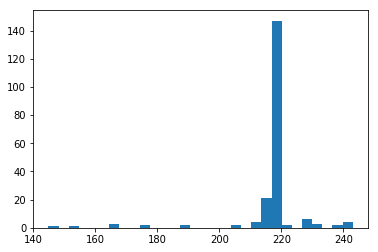

In [7]:
#set all images to print greyscale
#gray()

figure()

plt.hist(trainingFrames[:, 10, 12], bins=30);

## Show the mean image (the mean of each pixel over time)

Text(0.5, 1.0, 'Means')

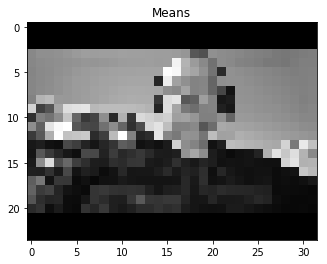

In [8]:
figure()
#show the mean image
display(imshow(means, interpolation='none', cmap='gray'))
title('Means')

## Show the standard deviation of each pixel. This is shown as a contour image, since the scaling can be controlled more easily

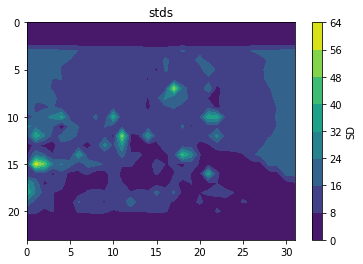

In [9]:
figure()

cf = plt.contourf(stds)#, vmin=0, vmax=128)
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = plt.colorbar(cf)
plt.gca().invert_yaxis()
cbar.ax.set_ylabel('SD')
title('stds')
display(cf)
       

## Display the skew (deviation from normal distribution) of each pixel. If these are too large, then the anomaly detector won't work very well for that pixel

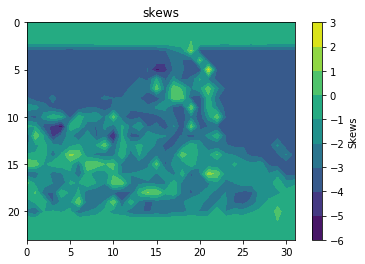

In [10]:
figure()

skewcf = plt.contourf(skews)
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = plt.colorbar(skewcf)
plt.gca().invert_yaxis()
cbar.ax.set_ylabel('Skews')
title('skews')
display(skewcf)

# Anomaly Detection

For a new sample image, calculate probability of each pixel. If it is lower than a threshold, then set the output pixel to 1 (showing an anomaly), else 0. 
If the proportion of anomalous pixels is greather than a threshold, then the detector is triggered (and in this case plays a sound).
To increase the sensitivity of the detector, reduce the 'anomalyProbabilityThreshold' variable.
To reduce the number of anomalous pixels required to trigger the trap, lower the 'proportionOfAnomalousPixelsToTriggerEvent' variable.

In [11]:
probabilityImage = np.zeros(shape=means.shape)

cap = cv2.VideoCapture(0)
fig = figure()
fig.clf()

count = 0
anomalyProbabilityThreshold = 1e-25
anomalyValues = []
proportionOfAnomalousPixelsToTriggerEvent = 0.05


while(cap.isOpened()):
    ret, frame = cap.read()
    
    res = cv2.resize(frame, None, fx=scalingFactor, fy=scalingFactor, interpolation = cv2.INTER_CUBIC)    

    del frame
    
    grayImage = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
   
    
    mn=1e99
    mx=0
    
    #check each pixel in the image to check if it is outside of the threshold probability value
    
    for y in range(grayImage.shape[0]):
        for x in range(grayImage.shape[1]):
            av = gaussian(grayImage[y][x], means[y][x], stds[y][x])
            probabilityImage[y][x] = 1.0 if av < anomalyProbabilityThreshold else 0.0
            if(probabilityImage[y][x] == 1): 
                res[y][x] = [0, 0, 255] #highlight anomalous pixels in red
    
    #make some larger output iqmages to display
    probabilityImageInc = cv2.resize(probabilityImage, None, fx=.75/scalingFactor, fy=.75/scalingFactor, interpolation = cv2.INTER_CUBIC)    
    resInc = cv2.resize(res, None, fx=.75/scalingFactor, fy=.75/scalingFactor, interpolation = 0)    
    
    #trigger the audio by setting the event that it is listening for
    if probabilityImage.mean() > proportionOfAnomalousPixelsToTriggerEvent:
        #print('Anomaly Detected')
        #print(datetime.now())
        if not evt.is_set():
            evt.set()

    #display the output images
    # show('Anomalous Pixels (Press Q to quit)', probabilityImageInc)
    cv2.imshow('Highlighted Pixels (Press Q to quit)', resInc)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()


<Figure size 432x288 with 0 Axes>